# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [3]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LM = meta.copy()
meta_LM.tail()

LM    22
Name: area, dtype: int64 22


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
17,1373,230302,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
18,1373,230302,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
19,1381,230307,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
20,1381,230307,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
21,1381,230307,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN


In [4]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

V1    6
Name: area, dtype: int64 6


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1324,200728,V1,200.0,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN


# df tidy for 1 set
grat 8ori 3isi

In [95]:
iset = 20

mouse = meta.loc[iset, 'mouse'].astype(str)
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
sess = '00' + meta.loc[iset, 'num'].astype(str)
print(mouse, date, area, sess)

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
for dirname in os.listdir(dir_data):
    if mouse in dirname and date in dirname and area in dirname and sess in dirname:
        dir_data = dir_data + dirname
        break

stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

1381 230307 LM 002
ncell: 87, nstim: 1, ntrial: 500, nframe: 207


(dict_keys(['stim_ori', 'isi_nframe', 'adapter_contrast']), (87, 500, 207))

trace_cell_avg: (207,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (207,)


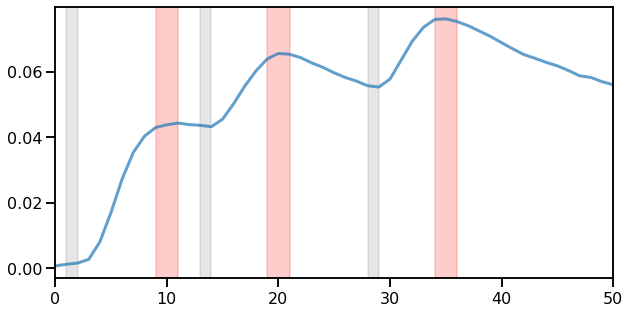

In [ ]:
## find resp window. TODO: auto detect
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 28
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell, alpha=0.7, linewidth=3)
ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')
plt.xlim(0, 50);

In [ ]:
## get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
resp_tg250 = resp_tg250 - base2

base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
resp_tg750 = resp_tg750 - base3

resp_ad.shape, resp_tg250.shape, resp_tg750.shape

((87, 500), (87, 500), (87, 500))

In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]

## stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
ntrial = resp_ad.shape[1]
resp_tg = np.zeros_like(resp_ad)
for itrial in range(ntrial):
    resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
# print(np.unique(trial_isi_nframe)) # 10 > 8 frame == 250 ms

R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

In [ ]:
ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

cell_id.shape, trial_id.shape, dfof.shape, len(resp_id)

((87000,), (87000,), (87000,), 87000)

In [ ]:
## map stim2 orientation to int
trial_stim_orien = [item[0] for item in stim_id['stim_ori']]
print(np.sort(np.unique(trial_stim_orien)))

trial_stim_orien_dict = {}
for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
    trial_stim_orien_dict[item] = i
trial_stim_orien_dict

trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
trial_isi_nframe = trial_isi_nframe[:ntrial]
trial_adapter_contrast = trial_adapter_contrast[:ntrial]

stim_id_col = np.tile(trial_stim_orien_int, ncell)
isi_col = np.tile(trial_isi_nframe, ncell)
ad_con_col = np.tile(trial_adapter_contrast, ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
adapter_id_col = np.zeros_like(stim_id_col)
isi_col = np.hstack((isi_col, isi_col))
ad_con_col = np.hstack((ad_con_col, ad_con_col))

stim_id_col.shape, isi_col.shape, ad_con_col.shape, adapter_id_col.shape

((87000,), (87000,), (87000,), (87000,))

In [ ]:
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                        'isi': isi_col, 'stim1_contrast': ad_con_col, 
                        'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id
0,0.399759,0,0,R1,8,1,3,0
1,0.027992,0,3,R1,23,1,6,0
2,0.054808,0,6,R1,8,1,3,0
3,0.029828,0,8,R1,23,1,5,0
4,-0.012044,0,11,R1,23,1,2,0
...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0
74294,-0.008860,86,496,R2,23,1,7,0
74295,-0.039800,86,497,R2,8,1,2,0
74296,-0.011214,86,498,R2,8,1,5,0


In [ ]:
## vis cell filter & img driven cell-stim filter

df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
        
df_tidy
# df_tidy.filter_cell.value_counts(), df_tidy.filter_cell_stim.value_counts()

ncell = 87, nstim = 8


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim
0,0.399759,0,0,R1,8,1,3,0,False,False
1,0.027992,0,3,R1,23,1,6,0,False,False
2,0.054808,0,6,R1,8,1,3,0,False,False
3,0.029828,0,8,R1,23,1,5,0,False,False
4,-0.012044,0,11,R1,23,1,2,0,False,False
...,...,...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0,True,False
74294,-0.008860,86,496,R2,23,1,7,0,True,False
74295,-0.039800,86,497,R2,8,1,2,0,True,False
74296,-0.011214,86,498,R2,8,1,5,0,True,False


# batch write df_tidy

In [119]:
meta = pd.concat([meta_V1, meta_LM], axis=0).reset_index(drop=True)
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg

    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    
    ## make stim info col: same as trial_id - tile then hsatck
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']]) # bool, ncell x 1

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()

    ## cell tuning in 3 possible ISI. well fit in isi 250 or 750
    fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat'))
    ori_pref_isi3 = fit_tuning['ori_pref'] # ncell x 3isi, [noad vs ad750 vs ad250]

    ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # for icell in np.arange(10):
    #     plt.plot(ori_pref_runs_sorted[icell, :])

    percentile_threshold = 0.90
    nrun = ori_pref_runs_sorted.shape[1]
    rand_idx = np.random.randint(100, 900, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]

    # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    R_square_250 = R_square[:, 2]
    well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)

    ncell = df_tidy.cell_id.unique().shape[0]
    for icell in np.arange(ncell):
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_isi3[icell, 0] # ori_pref_isi3 is ncell x 3isi, [noad vs ad750 vs ad250]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_isi3[icell, 1]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_isi3[icell, 2]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_noad1[icell]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_noad2[icell]

        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_well_fit_ad.csv'), index=False)

clear_output()

In [128]:
df_tidy[df_tidy.filter_cell_well_fit == True].groupby('filter_cell_well_fit_ad_250').cell_id.unique()

filter_cell_well_fit_ad_250
False                    [13]
True     [24, 26, 43, 45, 47]
Name: cell_id, dtype: object

# batch load df_tidy

In [129]:
meta = pd.concat([meta_V1, meta_LM], axis=0).reset_index(drop=True)
meta.sample(5, random_state=0)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
22,1380,230221,LM,150.0,3,1.0,NaN,grating,6s,NaN,TC not pretty
14,1337,210127,LM,150.0,3,1.0,NaN,grating,6s,NaN,NaN
17,1350,211020,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN


In [138]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_well_fit_ad.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [139]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307'] ['003' '002' '004'] ['V1' 'LM'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess
427815,0.086344,210120_003_54,193,R1,750,1,1,V1,0,True,...,165.383949,173.379033,159.682423,161.985687,167.252605,False,True,1337,210120,003
721733,0.637701,201217_002_31,54,R2,750,1,0,LM,0,False,...,36.709511,167.077267,141.960987,45.067411,37.879820,False,True,1329,201217,002
1571067,0.033343,230302_004_64,298,R2,250,1,6,LM,0,True,...,49.062328,55.881817,54.521602,67.500000,49.775698,True,True,1373,230302,004
537328,-0.131650,200804_003_19,306,R1,250,1,4,LM,0,True,...,168.457931,38.864084,89.630028,103.279800,170.688236,False,True,1322,200804,003
212258,0.024663,200803_002_58,122,R2,6000,0,4,V1,0,True,...,163.690503,165.522097,168.080808,162.912878,165.493479,True,True,1322,200803,002


# adaptation by area

(-0.42860578807658833,
 -0.5840592327956883,
 -0.45965902907813116,
 -0.5671159444338177)

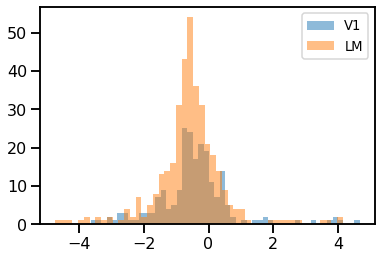

In [140]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_filter[df_filter.isi == 250]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])

plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
plt.legend();
np.mean(gb_adp_V1), np.mean(gb_adp_LM), \
    np.median(gb_adp_V1), np.median(gb_adp_LM)

# tuning bias
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell & isi
~~crude preference: take max-resp orientation as the preferred orien~~  
fitted preference: use pref from von mises curve fit

In [177]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def bin_ori_finer(x):
    # bin pref ori to n bins, with equal bin width
    nbin = 4 # n_edge = nbin + 1
    bin_width = 90 / nbin
    return (x // bin_width) * bin_width

def distance_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x)) # bin the distance to 5 edges, 0, 22.5, 45, 67.5, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias.csv'), index=False)

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
427815,0.086344,210120_003_54,193,R1,750,1,1,V1,0,True,...,167.252605,False,True,1337,210120,003,14.616051,0,6.620967,-7.995085
721733,0.637701,201217_002_31,54,R2,750,1,0,LM,0,False,...,37.879820,False,True,1329,201217,002,36.709511,45,12.922733,-23.786779
1571067,0.033343,230302_004_64,298,R2,250,1,6,LM,0,True,...,49.775698,True,True,1373,230302,004,49.062328,45,54.521602,5.459274
537328,-0.131650,200804_003_19,306,R1,250,1,4,LM,0,True,...,170.688236,False,True,1322,200804,003,11.542069,0,89.630028,78.087960
212258,0.024663,200803_002_58,122,R2,6000,0,4,V1,0,True,...,165.493479,True,True,1322,200803,002,16.309497,0,NaN,NaN


In [178]:
df_control = df_tidy.copy()

df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x))

df_control['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

df_control.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
427815,0.086344,210120_003_54,193,R1,750,1,1,V1,0,True,...,167.252605,False,True,1337,210120,003,18.014313,0,12.747395,-5.266917
721733,0.637701,201217_002_31,54,R2,750,1,0,LM,0,False,...,37.879820,False,True,1329,201217,002,45.067411,45,37.879820,-7.187590
1571067,0.033343,230302_004_64,298,R2,250,1,6,LM,0,True,...,49.775698,True,True,1373,230302,004,67.500000,90,49.775698,-17.724302
537328,-0.131650,200804_003_19,306,R1,250,1,4,LM,0,True,...,170.688236,False,True,1322,200804,003,76.720200,90,9.311764,-67.408436
212258,0.024663,200803_002_58,122,R2,6000,0,4,V1,0,True,...,165.493479,True,True,1322,200803,002,17.087122,0,14.506521,-2.580601


## tuning bias plot

In [182]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_tidy.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]

df_filter_control = df_control[(df_control.trial_id > -1) # placeholder, always true
                    & (df_control.filter_cell_vis == True)
                  #   & (df_control.filter_cell_stim == True)
                    & (df_control.filter_cell_well_fit == True)
                    & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_control.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]

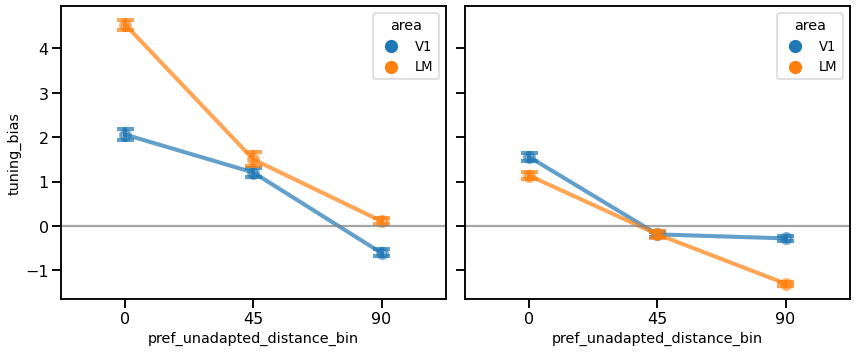

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                    ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter_control, hue='area',
                  errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                  ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

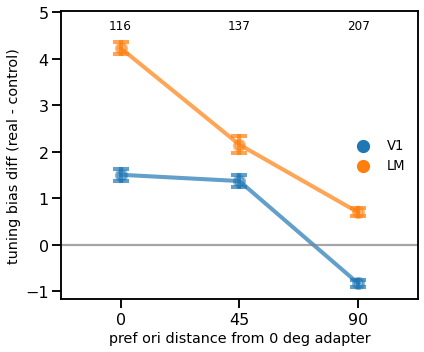

In [184]:
# df_bias_diff = df_filter.groupby(['area', 'pref_unadapted_distance_bin']).mean()['tuning_bias'].reset_index()
# df_bias_diff['tuning_bias'] = (df_filter.groupby(['area', 'pref_unadapted_distance_bin']).mean()['tuning_bias'].values 
#                      - df_filter_control.groupby(['area', 'pref_unadapted_distance_bin']).mean()['tuning_bias'].values)
# df_bias_diff = df_bias_diff.sort_values(by=['area'], ascending=False)

df_bias_diff = df_filter.copy()
df_bias_diff['tuning_bias'] = (df_filter['tuning_bias'] - df_filter_control['tuning_bias'])

fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_bias_diff, hue='area',
                   errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                   ax=axes,
                   )

# annotation above each dot, ncell
ncell_bin = df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 0.4)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, loc='center right')
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

## polar plot of tuning
before and after adaptation  
only use cells that are well fit in both conditions: noad and ad 250

In [149]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    'ori_pref_ad_250', 'ori_pref_noad']]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ] 
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)
    
df_tuning['pref_unadapted_distance'] = df_tuning['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tuning['pref_adapted_distance'] = df_tuning['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi

df_tuning['tuning_bias'] = df_tuning['pref_adapted_distance'] - df_tuning['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative
df_tuning.sort_values(by=['tuning_bias'], inplace=True) # df_tuning sort by tuning_bias_distance

df_tuning.sample(5, random_state=0)

100%|██████████| 460/460 [00:45<00:00, 10.09it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_fit_ad_250,ori_pref_ad_250,ori_pref_noad,tuning_noad,tuning_250,pref_unadapted_distance,pref_adapted_distance,tuning_bias
870658,-0.091087,210127_002_32,R2,6000,5,LM,True,1.0,True,20.042500,27.380783,"[0.0254098968148689, 0.12940786953766348, 0.05...","[0.024058067653353853, 0.0826463738453116, 0.0...",27.380783,20.042500,-7.338283
459679,0.018770,200721_002_1,R1,250,3,LM,True,1.0,True,119.827936,137.014672,"[0.028731078209631795, 0.034572557594218935, 0...","[-0.006370004742738847, 0.001508461222942701, ...",42.985328,60.172064,17.186735
1450172,0.010025,230302_003_60,R2,250,6,LM,True,1.0,True,92.569877,95.937496,"[0.004011170421542189, -0.0008451327614525161,...","[0.008517035949517578, -0.002955944956548057, ...",84.062504,87.430123,3.367619
650930,0.192211,201127_002_30,R1,250,3,LM,True,1.0,True,96.194461,98.601627,"[0.018031789728995547, 0.020335283587503528, -...","[-0.007928044230285647, -0.012781157576413663,...",81.398373,83.805539,2.407165
411556,0.030732,210120_003_4,R1,250,7,V1,True,1.0,True,84.988194,82.067674,"[0.021913499324308174, 0.014580241058665856, 0...","[0.02113181615410288, 0.033458390577826624, -0...",82.067674,84.988194,2.920520


In [151]:
for icell in tqdm(df_tuning.cell_id.unique()):

    # icell = '200720_003_63'
    # icell = '201119_003_70'

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))

    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)

    ## plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    ## plot pref ori (noad) as a line
    ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    if ori_pref_noad_opp > 2*np.pi:
        ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='--')

    ## plot pref ori (ad 250) as a line
    ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    if ori_pref_ad_250_opp > 2*np.pi:
        ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='--')

    ## add text at top left
    color = 'blue'
    minus_flag = 'pos'
    if tuning_bias < 0: # attractive bias
        color = 'red'
        minus_flag = 'neg'
    plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(min_val, max_val)

    ax.set_title('cell_id: {}'.format(icell))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias single cell'.replace('\\', '/')
    fig.savefig(os.path.join(dir_result, 'only well-fit-ad-250, observe circular variance', f'tuning_bias_{minus_flag}_{np.round(tuning_bias, 2)}_tuning_curves.png'), bbox_inches='tight', dpi=300)
    plt.close(fig)
    clear_output(wait=True)

100%|██████████| 460/460 [09:29<00:00,  1.24s/it]
